In [55]:
%matplotlib inline

## Software Comparison Project with NIDM-Results

This notebook demonstates how to reproduce the results presented in the Software Comparison Project publication using NIDM-Results packs available at [NeuroVault (2238)](http://neurovault.org/collections/2238/). We give visual comparisons between axial slices of the excursion set images and T-statistics for each software packages, as well as quantitative comparisons with Euler characteristics, Bland-Altman plots and Sørensen–Dice coefficients.


In [56]:
import os
from subprocess import check_call
import zipfile
import json
from urllib2 import urlopen, URLError, HTTPError
from urllib2 import Request
from nilearn import plotting

### Download the NIDM-Results packs from NeuroVault

 - Query NeuroVault's API to retreive all NIDM packs in collection 2238
 - Download and save the packs in sub-folder `input/ds109/` 

In [57]:
nv_collection ='2238'
study ='ds109'


request = Request('http://neurovault.org/api/collections/' + nv_collection + '/nidm_results/?limit=184&format=json')
response = urlopen(request)
elevations = response.read()
data = json.loads(elevations)

pwd = os.path.dirname(os.path.realpath('__file__'))
input_dir = os.path.join(pwd, "input")
data_dir = os.path.join(input_dir, study)

if not os.path.isdir(data_dir):
    if not os.path.isdir(input_dir):
        os.makedirs(input_dir)
    os.makedirs(data_dir)

for nidm_result in data["results"]:
    url = nidm_result["zip_file"]
    study_name = nidm_result["name"]

    localzip = os.path.join(data_dir, study_name + ".zip")
    localzip_rel = localzip.replace(pwd, '.')
    if not os.path.isfile(localzip):
        # Copy .nidm.zip export locally in a the data directory
        try:
            f = urlopen(url)
            print("downloading " + url + " at " + localzip_rel)
            with open(localzip, "wb") as local_file:
                local_file.write(f.read())
        except HTTPError, e:
            raise Exception(["HTTP Error:" + e.code + url])
        except URLError, e:
            raise Exception(["URL Error:" + e.reason + url])
    else:
        print(url + " already downloaded at " + localzip_rel)

for afni_image, local_name in (
        ('Negative_clustered_t_stat.nii.gz', 'afni_exc_set_neg.nii.gz'), 
        ('Positive_clustered_t_stat.nii.gz', 'afni_exc_set_pos.nii.gz'),
        ('3dMEMA_result_t_stat_masked.nii.gz', 'afni_stat.nii.gz'),
        ('mask.nii.gz', 'afni_mask.nii.gz')):

    url = "http://neurovault.org/media/images/" + nv_collection + '/' + afni_image
    local_file = os.path.join(data_dir, local_name)
    if not os.path.isfile(local_file):
        # Copy file locally in a the data directory
        try:
            f = urlopen(url)
            print("downloading " + url + " at " + local_file)
            with open(local_file, "wb") as local_fid:
                local_fid.write(f.read())
        except HTTPError, e:
            raise Exception(["HTTP Error:" + str(e.code) + url])
        except URLError, e:
            raise Exception(["URL Error:" + e.reason + url])
    else:
        print(url + " already downloaded at " + local_file)

for euler_char_file, local_name in (
        ('AFNI/LEVEL2/euler_chars.csv', 'afni_euler_chars.csv'),
        ('FSL/LEVEL2/group.gfeat/cope1.feat/stats/euler_chars.csv', 'fsl_euler_chars.csv'),
        ('SPM/LEVEL2/euler_chars.csv', 'spm_euler_chars.csv')):

    url = "https://raw.githubusercontent.com/AlexBowring/Software_Comparison/comparisons/" + study + "/" + euler_char_file
    local_file = os.path.join(data_dir, local_name)
    if not os.path.isfile(local_file):
        # Copy file locally in a the data directory
        try:
            f = urlopen(url)
            print("downloading " + url + " at " + local_file)
            with open(local_file, "wb") as local_fid:
                local_fid.write(f.read())
        except HTTPError, e:
            raise Exception(["HTTP Error:" + str(e.code) + url])
        except URLError, e:
            raise Exception(["URL Error:" + e.reason + url])
    else:
        print(url + " already downloaded at " + local_file)
        
for resliced_image in (('afni_fsl_reslice.nii.gz', 'afni_fsl_pos_exc_reslice.nii.gz','afni_fsl_neg_exc_reslice.nii.gz',
                        'afni_spm_reslice.nii.gz', 'afni_spm_pos_exc_reslice.nii.gz','afni_spm_neg_exc_reslice.nii.gz',
                        'fsl_spm_reslice.nii.gz', 'fsl_spm_pos_exc_reslice.nii.gz','fsl_spm_neg_exc_reslice.nii.gz')):
    url = "http://neurovault.org/media/images/" + nv_collection + '/' + resliced_image
    local_file = os.path.join(data_dir, resliced_image)
    if not os.path.isfile(local_file):
        # Copy file locally in a the data directory
        try:
            f = urlopen(url)
            print("downloading " + url + " at " + local_file)
            with open(local_file, "wb") as local_fid:
                local_fid.write(f.read())
        except HTTPError, e:
            raise Exception(["HTTP Error:" + str(e.code) + url])
        except URLError, e:
            raise Exception(["URL Error:" + e.reason + url])
    else:
        print(url + " already downloaded at " + local_file)


http://neurovault.org/collections/2238/group.gfeat.nidm.zip already downloaded at ./input/ds109/group.gfeat.nidm.zip
http://neurovault.org/collections/2238/spm_0001.nidm.zip already downloaded at ./input/ds109/spm_0001.nidm.zip
http://neurovault.org/collections/2238/spm_0002.nidm.zip already downloaded at ./input/ds109/spm_0002.nidm.zip
http://neurovault.org/media/images/2238/Negative_clustered_t_stat.nii.gz already downloaded at /Users/maullz/Desktop/Software_Comparison/input/ds109/afni_exc_set_neg.nii.gz
http://neurovault.org/media/images/2238/Positive_clustered_t_stat.nii.gz already downloaded at /Users/maullz/Desktop/Software_Comparison/input/ds109/afni_exc_set_pos.nii.gz
http://neurovault.org/media/images/2238/3dMEMA_result_t_stat_masked.nii.gz already downloaded at /Users/maullz/Desktop/Software_Comparison/input/ds109/afni_stat.nii.gz
http://neurovault.org/media/images/2238/mask.nii.gz already downloaded at /Users/maullz/Desktop/Software_Comparison/input/ds109/afni_mask.nii.gz
ht

In [58]:
import zipfile
import shutil

# *** SPM group activations
spm_pack = open('./input/' + study + '/spm_0001.nidm.zip', 'rb')
z = zipfile.ZipFile(spm_pack)
z.extract('ExcursionSet.nii.gz', './input/' + study + '/')
z.extract('Mask.nii.gz', './input/' + study + '/')
z.extract('TStatistic.nii.gz', './input/' + study + '/')

# Thresholded statistics
spm_exc_set_file = './input/' + study + '/spm_exc_set.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet.nii.gz', spm_exc_set_file)

# Unthresholded statistics
spm_stat_file = './input/' + study + '/spm_stat.nii.gz'
shutil.move('./input/' + study + '/TStatistic.nii.gz', spm_stat_file)

# Analysis mask
spm_mask_file = './input/' + study + '/spm_mask.nii.gz'
shutil.move('./input/' + study + '/Mask.nii.gz', spm_mask_file)

# *** SPM group deactivations
spm_deact_pack = open('./input/' + study + '/spm_0002.nidm.zip', 'rb')
z = zipfile.ZipFile(spm_deact_pack)
z.extract('ExcursionSet.nii.gz', './input/' + study + '/')

# Thresholded statistics
spm_exc_set_file_neg = './input/' + study + '/spm_exc_set_neg.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet.nii.gz', spm_exc_set_file_neg)

# *** FSL group activations and deactivations
fsl_pack = open('./input/' + study + '/group.gfeat.nidm.zip', 'rb')
z = zipfile.ZipFile(fsl_pack)
z.extract('ExcursionSet_T001.nii.gz', './input/' + study + '/')
z.extract('ExcursionSet_T002.nii.gz', './input/' + study + '/')
z.extract('Mask.nii.gz', './input/' + study + '/')
z.extract('TStatistic_T001.nii.gz', './input/' + study + '/')

# Thresholded statistics
fsl_exc_set_file = './input/' + study + '/fsl_exc_set.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet_T001.nii.gz', fsl_exc_set_file)
fsl_exc_set_file_neg = './input/' + study + '/fsl_exc_set_neg.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet_T002.nii.gz', fsl_exc_set_file_neg)

# Unthresholded statistics
fsl_stat_file = './input/' + study + '/fsl_stat.nii.gz'
shutil.move('./input/' + study + '/TStatistic_T001.nii.gz', fsl_stat_file)

# Analysis mask
fsl_mask_file = './input/' + study + '/fsl_mask.nii.gz'
shutil.move('./input/' + study + '/Mask.nii.gz', fsl_mask_file)

# *** AFNI group activations and deactivations
afni_mask_file = './input/' + study + '/afni_mask.nii.gz'
afni_exc_set_file = './input/' + study + '/afni_exc_set_pos.nii.gz'
afni_exc_set_file_neg = './input/' + study + '/afni_exc_set_neg.nii.gz'
afni_stat_file = './input/' + study + '/afni_stat.nii.gz'

exc_sets = dict()
exc_sets["spm"] = (spm_mask_file, (spm_exc_set_file, spm_exc_set_file_neg), spm_stat_file)
exc_sets["fsl"] = (fsl_mask_file, (fsl_exc_set_file, fsl_exc_set_file_neg), fsl_stat_file)
exc_sets["afni"] = (afni_mask_file, (afni_exc_set_file, afni_exc_set_file_neg), afni_stat_file)

# *** Resliced images
afni_fsl_reslice = './input/' + study + '/afni_fsl_reslice.nii.gz'
afni_fsl_pos_exc_reslice = './input/' + study + '/afni_fsl_pos_exc_reslice.nii.gz'
afni_fsl_neg_exc_reslice = './input/' + study + '/afni_fsl_neg_exc_reslice.nii.gz'

afni_spm_reslice = './input/' + study + '/afni_spm_reslice.nii.gz'
afni_spm_pos_exc_reslice = './input/' + study + '/afni_spm_pos_exc_reslice.nii.gz'
afni_spm_neg_exc_reslice = './input/' + study + '/afni_spm_neg_exc_reslice.nii.gz'

fsl_spm_reslice  = './input/' + study + '/fsl_spm_reslice.nii.gz'
fsl_spm_pos_exc_reslice = './input/' + study + '/fsl_spm_pos_exc_reslice.nii.gz'
fsl_spm_neg_exc_reslice = './input/' + study + '/fsl_spm_neg_exc_reslice.nii.gz'

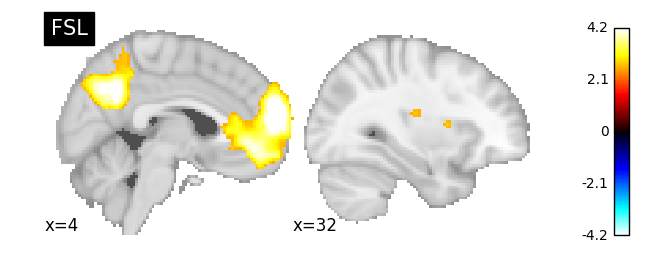

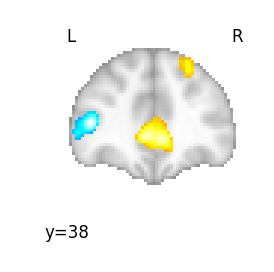

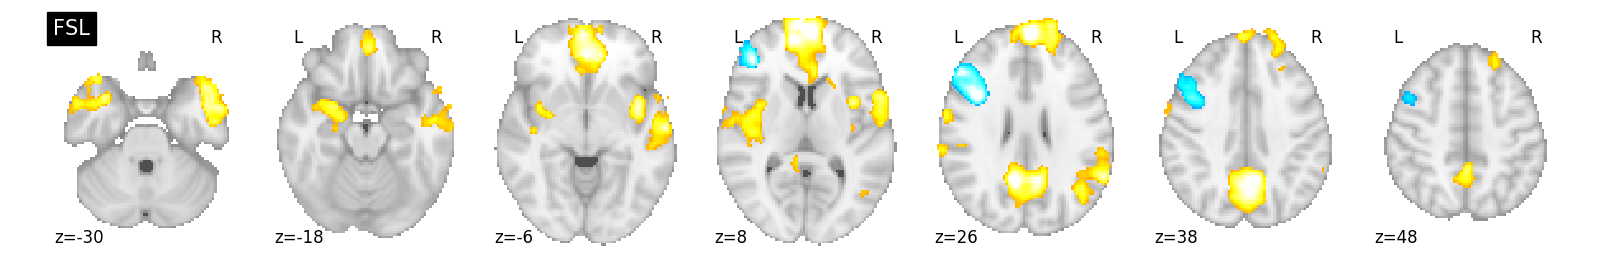

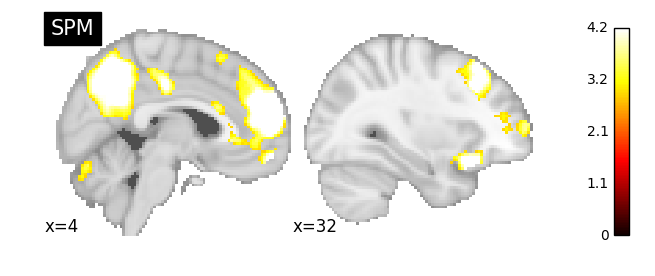

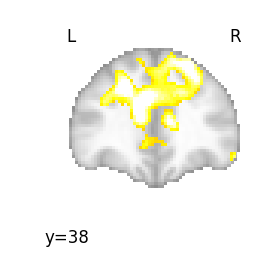

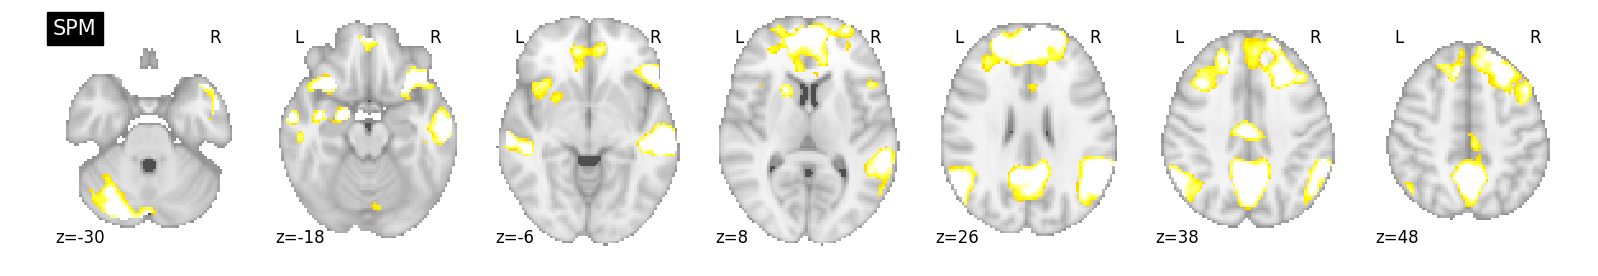

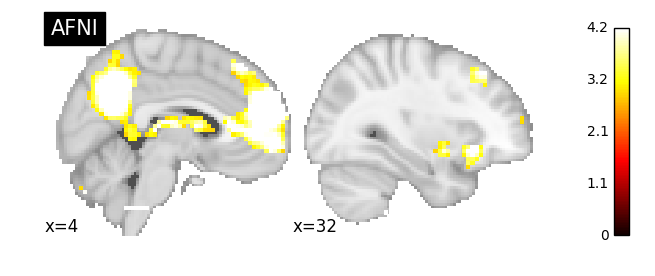

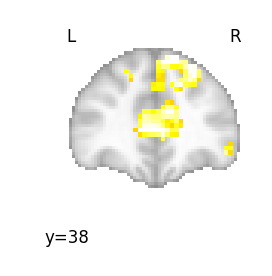

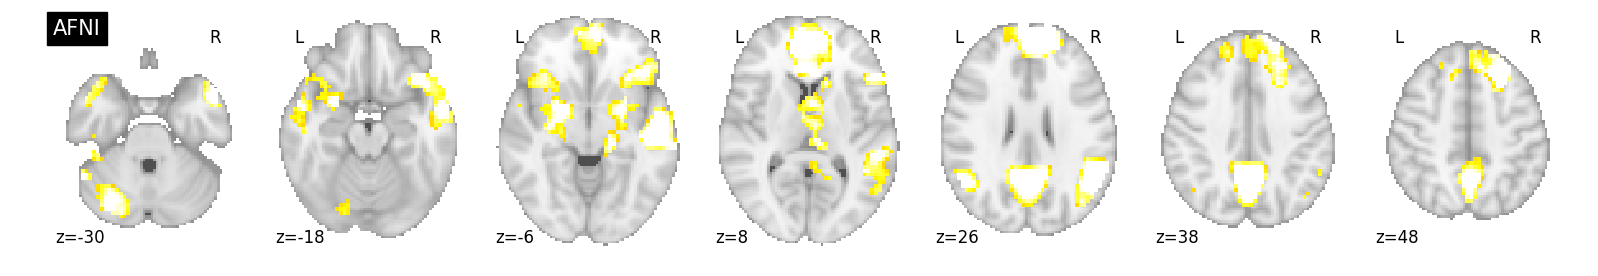

In [59]:
from nilearn import plotting
from nilearn.image import math_img
import numpy as np
from nilearn.masking import apply_mask
from nilearn.image import load_img, new_img_like
from nilearn._utils.niimg_conversions import _safe_get_data
import nibabel as nib

for soft, (mask_file, (exc_set_file, exc_set_file_neg), stat_file) in exc_sets.items():
    # Remove NaNs
    n = nib.load(exc_set_file)
    d = n.get_data()
    exc_set_nonan = nib.Nifti1Image(np.nan_to_num(d), n.affine, header=n.header)
    
    n = nib.load(exc_set_file_neg)
    d = n.get_data()
    exc_set_neg_nonan = nib.Nifti1Image(np.nan_to_num(d), n.affine, header=n.header)
    
    # Combine activations and deactivations in a single image 
    to_display = math_img("img1-img2", img1=exc_set_nonan, img2=exc_set_neg_nonan)

    # Display x=4, y=32 and y=38 as in the manuscript
    display = plotting.plot_stat_map(to_display, display_mode='x', cut_coords=[4, 32], draw_cross=False, colorbar=True, 
                           title=soft.upper(), threshold=0.000001, vmax=4.2)
    display = plotting.plot_stat_map(to_display, cut_coords=[38], draw_cross=False, display_mode='y', 
                           threshold=0.000001, colorbar=False, vmax=4.2)
    # Additional plot: slices along z
    display = plotting.plot_stat_map(to_display, cut_coords=[-30, -18, -6, 8, 26, 38, 48], draw_cross=False, display_mode='z', 
                           threshold=0.000001, colorbar=False, vmax=4.2, title=soft.upper())
#     # Analysis mask
#     display = plotting.plot_roi(mask_file, title=soft.upper()+': Analysis mask')

#     # Analysis mask
#     display = plotting.plot_roi(mask_file, title=soft.upper()+': Analysis mask', 
#                                 cut_coords=7, draw_cross=False, display_mode='z')


plotting.show()

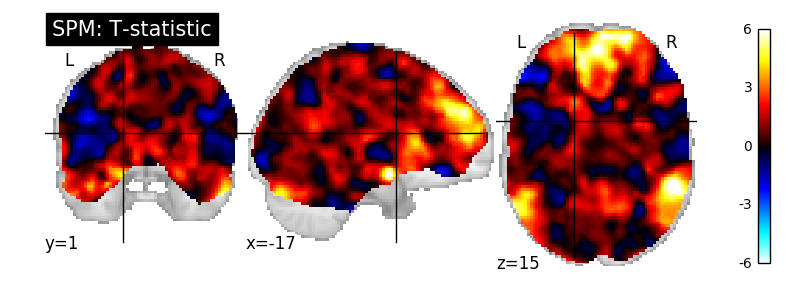

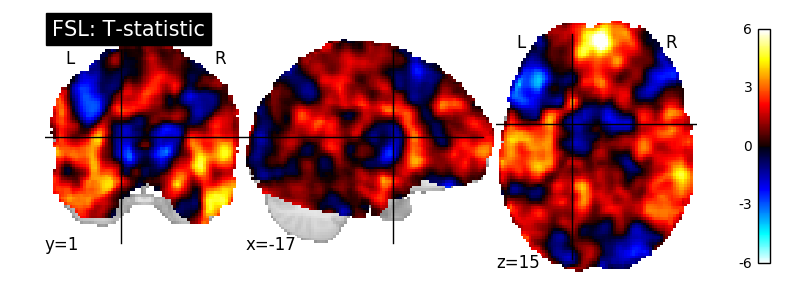

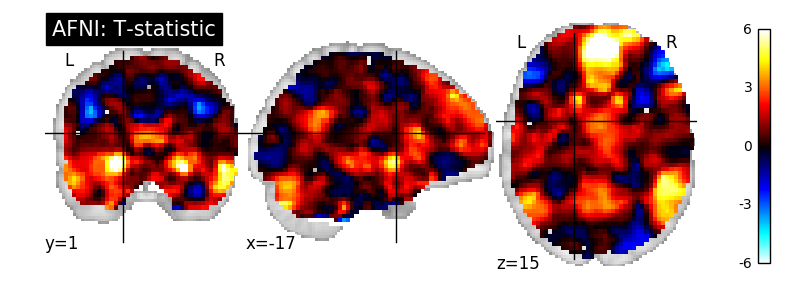

In [60]:
from nilearn import plotting
plotting.plot_stat_map(spm_stat_file, vmax=6, title="SPM: T-statistic", display_mode='ortho', cut_coords=[-17, 1, 15])
plotting.plot_stat_map(fsl_stat_file, vmax=6, title="FSL: T-statistic", display_mode='ortho', cut_coords=[-17, 1, 15])
plotting.plot_stat_map(afni_stat_file, vmax=6, title="AFNI: T-statistic", display_mode='ortho', cut_coords=[-17, 1, 15])

In [61]:
import pandas as pd

afni_euler_chars = pd.read_csv('./input/' + study + '/afni_euler_chars.csv', header=None, names=['Threshold','AFNI EC'])
fsl_euler_chars = pd.read_csv('./input/' + study + '/fsl_euler_chars.csv', usecols=[1], header=None, names=['FSL EC'])
spm_euler_chars = pd.read_csv('./input/' + study + '/spm_euler_chars.csv', usecols=[1], header=None, names=['SPM EC'])
euler_chars = pd.concat([afni_euler_chars, fsl_euler_chars, spm_euler_chars], axis=1)

euler_chars

,Threshold,AFNI EC,FSL EC,SPM EC
0,-6.0,5,2,1
1,-5.9,5,2,1
2,-5.8,5,2,1
3,-5.7,5,2,1
4,-5.6,5,2,1
5,-5.5,5,4,1
6,-5.4,5,4,1
7,-5.3,5,4,1
8,-5.2,5,4,1
9,-5.1,5,6,1


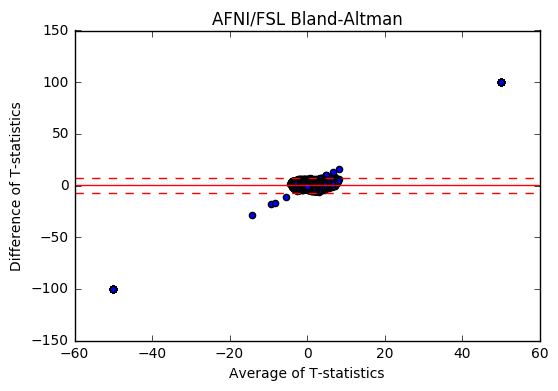

Mean = 0.0523681
SD = 3.79517


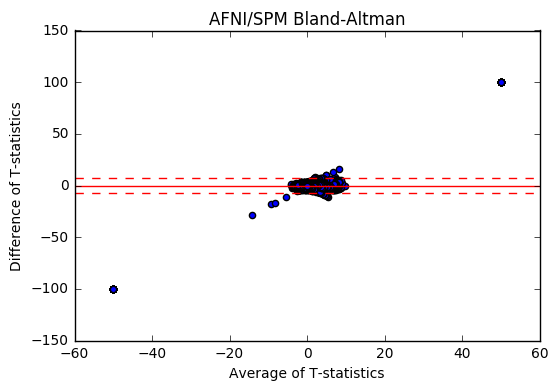

Mean = -0.04601
SD = 3.72633


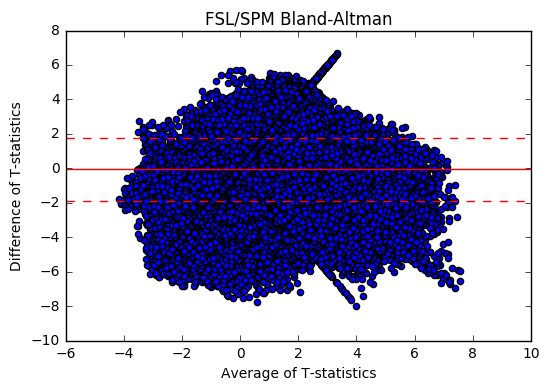

Mean = -0.0651279
SD = 0.925995


In [62]:
import matplotlib.pyplot as plt

# Load up all statistic images
afni = nib.load(afni_stat_file)
fsl = nib.load(fsl_stat_file)
spm = nib.load(spm_stat_file)

afni_fsl = nib.load(afni_fsl_reslice)
afni_spm = nib.load(afni_spm_reslice)
fsl_spm  = nib.load(fsl_spm_reslice)

# Get data from statistic images
afni_dat = afni.get_data()
fsl_dat = fsl.get_data()
spm_dat = spm.get_data()
afni_fsl_dat = afni_fsl.get_data()
afni_spm_dat = afni_spm.get_data()
fsl_spm_dat = fsl_spm.get_data()

# Remove NaNs from resliced images
afni_fsl_dat = nib.Nifti1Image(np.nan_to_num(afni_fsl_dat), afni_fsl.affine, header=afni_fsl.header).get_data()
afni_spm_dat = nib.Nifti1Image(np.nan_to_num(afni_spm_dat), afni_spm.affine, header=afni_spm.header).get_data()
fsl_spm_dat = nib.Nifti1Image(np.nan_to_num(fsl_spm_dat), fsl_spm.affine, header=fsl_spm.header).get_data()

# Get dimensions and reshape data to 2 dimensions
afni_dim = afni_dat.shape
fsl_dim = fsl_dat.shape 

afni_proddim = np.prod(afni_dim)
fsl_proddim = np.prod(fsl_dim)

afni_2d = np.reshape(afni_dat, afni_proddim)
afni_fsl_2d = np.reshape(afni_fsl_dat, afni_proddim)
afni_spm_2d = np.reshape(afni_spm_dat, afni_proddim)
fsl_2d = np.reshape(fsl_dat, fsl_proddim)
fsl_spm_2d = np.reshape(fsl_spm_dat, fsl_proddim)

def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference
    
    plt.scatter(mean, diff, *args, **kwargs)
    mean = plt.axhline(md,           color='red', linestyle='-')
    pos_95_prct = plt.axhline(md + 1.96*sd, color='red', linestyle='--')
    neg_95_prct = plt.axhline(md - 1.96*sd, color='red', linestyle='--')
    plt.xlabel('Average of T-statistics')
    plt.ylabel('Difference of T-statistics')
    return md, sd

bland = bland_altman_plot(afni_2d, afni_fsl_2d)
plt.title('AFNI/FSL Bland-Altman')
plt.show()
mean, sd = bland
print "Mean = %s" % mean
print "SD = %s" % sd

bland = bland_altman_plot(afni_2d, afni_spm_2d)
plt.title('AFNI/SPM Bland-Altman')
plt.show()
mean, sd = bland
print "Mean = %s" % mean
print "SD = %s" % sd

bland = bland_altman_plot(fsl_2d, fsl_spm_2d)
plt.title('FSL/SPM Bland-Altman')
plt.show()
mean, sd = bland
print "Mean = %s" % mean
print "SD = %s" % sd


In [63]:
# Load up all excursion set images
afni_pos = nib.load(afni_exc_set_file)
afni_neg = nib.load(afni_exc_set_file_neg)
fsl_pos = nib.load(fsl_exc_set_file)
fsl_neg = nib.load(fsl_exc_set_file_neg)
spm_pos = nib.load(spm_exc_set_file)
spm_neg = nib.load(spm_exc_set_file_neg)
afni_fsl_pos = nib.load(afni_fsl_pos_exc_reslice)
afni_fsl_neg = nib.load(afni_fsl_neg_exc_reslice)
afni_spm_pos = nib.load(afni_spm_pos_exc_reslice)
afni_spm_neg = nib.load(afni_spm_neg_exc_reslice)
fsl_spm_pos = nib.load(fsl_spm_pos_exc_reslice) 
fsl_spm_neg = nib.load(fsl_spm_neg_exc_reslice)

# Get data from excursion set images
afni_pos_dat = afni_pos.get_data()
afni_neg_dat = afni_neg.get_data()
fsl_pos_dat = fsl_pos.get_data()
fsl_neg_dat = fsl_neg.get_data()
spm_pos_dat = spm_pos.get_data()
spm_neg_dat = spm_neg.get_data()
afni_fsl_pos_dat = afni_fsl_pos.get_data()
afni_fsl_neg_dat = afni_fsl_neg.get_data()
afni_spm_pos_dat = afni_spm_pos.get_data()
afni_spm_neg_dat = afni_spm_neg.get_data()
fsl_spm_pos_dat = fsl_spm_pos.get_data()
fsl_spm_neg_dat = fsl_spm_neg.get_data()

# Remove NaNs from images
afni_pos_dat = nib.Nifti1Image(np.nan_to_num(afni_pos_dat), afni_pos.affine, header=afni_pos.header).get_data()
afni_neg_dat = nib.Nifti1Image(np.nan_to_num(afni_neg_dat), afni_neg.affine, header=afni_neg.header).get_data()
fsl_pos_dat = nib.Nifti1Image(np.nan_to_num(fsl_pos_dat), fsl_pos.affine, header=fsl_pos.header).get_data()
fsl_neg_dat = nib.Nifti1Image(np.nan_to_num(fsl_neg_dat), fsl_neg.affine, header=fsl_neg.header).get_data()
spm_pos_dat = nib.Nifti1Image(np.nan_to_num(spm_pos_dat), spm_pos.affine, header=spm_pos.header).get_data()
spm_neg_dat = nib.Nifti1Image(np.nan_to_num(spm_neg_dat), spm_neg.affine, header=spm_neg.header).get_data()
afni_fsl_pos_dat = nib.Nifti1Image(np.nan_to_num(afni_fsl_pos_dat), afni_fsl_pos.affine, header=afni_fsl_pos.header).get_data()
afni_fsl_neg_dat = nib.Nifti1Image(np.nan_to_num(afni_fsl_neg_dat), afni_fsl_neg.affine, header=afni_fsl_neg.header).get_data()
afni_spm_pos_dat = nib.Nifti1Image(np.nan_to_num(afni_spm_pos_dat), afni_spm_pos.affine, header=afni_spm_pos.header).get_data()
afni_spm_neg_dat = nib.Nifti1Image(np.nan_to_num(afni_spm_neg_dat), afni_spm_neg.affine, header=afni_spm_pos.header).get_data()
fsl_spm_pos_dat = nib.Nifti1Image(np.nan_to_num(fsl_spm_pos_dat), fsl_spm_pos.affine, header=fsl_spm_pos.header).get_data()
fsl_spm_neg_dat = nib.Nifti1Image(np.nan_to_num(fsl_spm_neg_dat), fsl_spm_neg.affine, header=fsl_spm_neg.header).get_data()
    
def sorrenson_dice(data1, data2):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    data1 = np.absolute(data1)
    data2 = np.absolute(data2)
    
    low_value_indices_data1 = data1 < 0.1
    high_value_indices_data1 = data1 > 0.1
    low_value_indices_data2 = data2 < 0.1
    high_value_indices_data2 = data2 >0.1
    
    intersection_data = data1 
    intersection_data[low_value_indices_data2] = 0 # All values close to 0 in data1 or data2 are 0 in the intersection array
    intersection_indices = intersection_data > 0.1
    intersection_data[intersection_indices] = 1 # All values in the union of data1 and data2 are set to 1
    numerator = 2*np.sum(intersection_data)
    
    data1[low_value_indices_data1] = 0
    data1[high_value_indices_data1] = 1
    data2[low_value_indices_data2] = 0
    data2[high_value_indices_data2] = 1
    denominator = np.sum(data1) + np.sum(data2)
    
    dice_coefficient = numerator/denominator
    return dice_coefficient

afni_fsl_pos_dice = sorrenson_dice(afni_pos_dat, afni_fsl_pos_dat)
afni_fsl_neg_dice = sorrenson_dice(afni_neg_dat, afni_fsl_neg_dat)
afni_spm_pos_dice = sorrenson_dice(afni_pos_dat, afni_spm_pos_dat)
afni_spm_neg_dice = sorrenson_dice(afni_neg_dat, afni_spm_neg_dat)
fsl_spm_pos_dice = sorrenson_dice(fsl_pos_dat, fsl_spm_pos_dat)
fsl_spm_neg_dice = sorrenson_dice(fsl_neg_dat, fsl_spm_neg_dat)

print "AFNI/FSL positive activation dice coefficient = %s" % afni_fsl_pos_dice
print "AFNI/FSL negative activation dice coefficient = %s" % afni_fsl_neg_dice
print "AFNI/SPM positive activation dice coefficient = %s" % afni_spm_pos_dice
print "AFNI/SPM negative activation dice coefficient = %s" % afni_spm_neg_dice
print "FSL/SPM positive activation dice coefficient = %s" % fsl_spm_pos_dice
print "FSL/SPM negative activation dice coefficient = %s" % fsl_spm_neg_dice

AFNI/FSL positive activation dice coefficient = 0.41012111764
AFNI/FSL negative activation dice coefficient = 0.0
AFNI/SPM positive activation dice coefficient = 0.511636946698
AFNI/SPM negative activation dice coefficient = nan
FSL/SPM positive activation dice coefficient = 0.354767489996
FSL/SPM negative activation dice coefficient = 0.0
